In [5]:
import os
import sys
sys.path.append("/home/ksavevska/talos_ws/dmpbbo")
import dmpbbo.json_for_cpp as jc
from dmpbbo.dmps.Trajectory import Trajectory
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import quaternion_integrate, matrix_from_quaternion, plot_basis
import copy

In [55]:
dmp_0 = jc.loadjson("results_short_traj_3/dmp_rarm_initial.json")

In [56]:
dmp_0.y_attr

array([ 0.58934402, -0.28802313, -0.08837862])

In [57]:
dmp_T = jc.loadjson("results_short_traj_3/updates_rarm/update00149/eval_dmp.json")

In [58]:
dmp_T.y_attr

array([ 0.63671603, -0.38092111, -0.00403379])

In [6]:
plt.rcParams.update({"text.usetex": True,
              "font.family": "serif",
              "font.serif": ["Computer Modern Roman"], 
              "font.weight": "medium",
              "font.style": "normal",
              "font.size": 10.95,
              "figure.figsize": [4.9, 3.5],
              "axes.linewidth": 0.6})

In [7]:
def calculate_dist_to_cop(cost_vars):                        
    n_misc = 15                                                                                         
    cop_x = cost_vars[:,-n_misc]                                  
    cop_y = cost_vars[:,-n_misc+1]                                   

    rf_y = cost_vars[0, -2]                                                            
    lf_y = cost_vars[0, -5]                       
    rf_x = cost_vars[0, -3]
    lf_x = cost_vars[0, -6]             
    ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
    dist_to_cop = np.sum((1/len(cop_x))*np.sqrt((cop_x - ref_cop[0])**2 + (cop_y - ref_cop[1])**2))
    return dist_to_cop 

def plot_costs(results_folder, subplots=False):
    updates = np.sort(os.listdir(os.path.join(results_folder, "updates_rarm")))
    with open(results_folder + '/plot_configs.json') as config_file:
        plot_configs = json.load(config_file)
    
    costs = []
    dist_to_cop = []
    for update in updates:
        if "update0" in update and update != "update00150":
            cost_files = np.sort(os.listdir(os.path.join(results_folder, "updates_rarm/"+update)))
            for cost in cost_files:
                if "eval_costs.txt" in cost:
                    c = np.loadtxt(os.path.join(results_folder+"/updates_rarm/"+update, cost))
                    costs.append(c)
                    cv = np.loadtxt(results_folder+"/updates_rarm/"+update+"/eval_cost_vars.txt")
                    d=calculate_dist_to_cop(cv)                                                    
                    dist_to_cop.append(d)
    columns = plot_configs["weights"].keys()
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost", "traj_cost"]
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost"]

    res = pd.DataFrame(columns=columns, data=costs)
    res["stab_cost"] = dist_to_cop

    weights = plot_configs["weights"]
    titles = plot_configs["titles"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]

    if subplots:
        fig, axs = plt.subplots(1, len(columns), figsize=(4.9*len(columns), 3.5))
        for i, col in enumerate(res.columns):
            axs[i].plot(res[col][res["cost"]<10]/weights[col], color=colors[i])
            axs[i].set_title(titles[col])
            axs[i].grid()
        plt.show()
    else:
        for i, col in enumerate(res.columns):
            plt.plot(res[col]/weights[col], color=colors[i])
            plt.title(titles[col])
            plt.grid()
            # plt.savefig(results_folder+"/"+titles[col]+".pdf", dpi=1000, format="pdf", bbox_inches='tight')
            plt.show()
                                                           
    return res

In [8]:
def plot_ee_traj(results_folder):
    cost_vars_0 = np.loadtxt(results_folder + "/updates_rarm/update00001/eval_cost_vars.txt")
    cost_vars_T = np.loadtxt(results_folder + "/updates_rarm/update00149/eval_cost_vars.txt")
    n_misc = 15
    n=0
    ee_pos_x_0 = cost_vars_0[n:,-n_misc+2]
    ee_pos_y_0 = cost_vars_0[n:,-n_misc+3]
    ee_pos_z_0 = cost_vars_0[n:,-n_misc+4]
    pos_0 = np.column_stack((ee_pos_x_0, ee_pos_y_0, ee_pos_z_0))
    ee_rot_x_0 = cost_vars_0[n:,-n_misc+5]
    ee_rot_y_0 = cost_vars_0[n:,-n_misc+6]
    ee_rot_z_0 = cost_vars_0[n:,-n_misc+7]
    ee_rot_w_0 = cost_vars_0[n:,-n_misc+8]
    Q_0 = np.column_stack((ee_rot_w_0, ee_rot_x_0, ee_rot_y_0, ee_rot_z_0))
    
    ee_pos_x_T = cost_vars_T[n:,-n_misc+2]
    ee_pos_y_T = cost_vars_T[n:,-n_misc+3]
    ee_pos_z_T = cost_vars_T[n:,-n_misc+4]
    pos_T = np.column_stack((ee_pos_x_T, ee_pos_y_T, ee_pos_z_T))
    ee_rot_x_T = cost_vars_T[n:,-n_misc+5]
    ee_rot_y_T = cost_vars_T[n:,-n_misc+6]
    ee_rot_z_T = cost_vars_T[n:,-n_misc+7]
    ee_rot_w_T = cost_vars_T[n:,-n_misc+8]
    Q_T = np.column_stack((ee_rot_w_T, ee_rot_x_T, ee_rot_y_T, ee_rot_z_T))
    
    fig3d = plt.figure(figsize=(10,6))
    # ax = Axes3D(fig3d)
    ax = fig3d.add_subplot(111, projection="3d")
    ax.view_init(None, 220)
    n=0
    ax.plot(ee_pos_x_0[n:], ee_pos_y_0[n:], ee_pos_z_0[n:], linewidth=1.5, label="initial")
    ax.plot(ee_pos_x_T[n:], ee_pos_y_T[n:], ee_pos_z_T[n:], linewidth=1.5, label="optimal")
    ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
    # for i in [-1]:
    #     R_0 = matrix_from_quaternion(Q_0[i])
    #     p_0 = pos_0[i]
    #     R_T = matrix_from_quaternion(Q_T[i])
    #     p_T = pos_T[i]
    #     ax = plot_basis(ax=ax, s=0.05, R=R_0, p=p_0)
    #     ax = plot_basis(ax=ax, s=0.05, R=R_T, p=p_T)
    # ax = plot_basis(ax=ax, s=0.05, R=matrix_from_quaternion([0.5, 0.5, -0.5, -0.5]), p=[0.65,-0.4, 0.0])

    ax.legend()
    ax.set_title("EE trajectory comparison")
    # plt.savefig(results_folder+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
    plt.show()
    return ' '

In [9]:
def plot_dmps(results_folder):
    dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
    ts_rarm = dmp_0.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
    traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

    dmp_T = jc.loadjson(results_folder + "/updates_rarm/update00149/eval_dmp.json")
    ts_rarm = dmp_T.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_T.analytical_solution()
    traj_sample_T = dmp_T.states_as_trajectory(ts_rarm, xs, xds)

    dmp_traj = np.column_stack((traj_sample.ys, traj_sample.yds, traj_sample.ydds))
    dmp_traj_T = np.column_stack((traj_sample_T.ys, traj_sample_T.yds, traj_sample_T.ydds))

    plt.rcParams['axes.grid'] = True
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    ax[0,0].plot(dmp_traj[:,0], label="initial", color="red", linestyle="--")
    ax[0,0].plot(dmp_traj_T[:,0], label="optimal", color="red", linestyle="-")
    ax[0,0].set_ylabel("x")
    ax[0,0].set_title("Position")
    ax[0,0].legend()
    ax[1,0].plot(dmp_traj[:,1], label="initial", color="blue", linestyle="--")
    ax[1,0].plot(dmp_traj_T[:,1], label="optimal", color="blue", linestyle="-")
    ax[1,0].set_ylabel("y")
    ax[1,0].legend()
    ax[2,0].plot(dmp_traj[:,2], label="initial", color="green", linestyle="--")
    ax[2,0].plot(dmp_traj_T[:,2], label="optimal", color="green", linestyle="-")
    ax[2,0].set_ylabel("z")
    ax[2,0].legend()

    ax[0,1].plot(dmp_traj[:,3], color="red", linestyle="--")
    ax[0,1].plot(dmp_traj_T[:,3], color="red", linestyle="-")
    ax[0,1].set_title("Velocity")
    ax[1,1].plot(dmp_traj[:,4], color="blue", linestyle="--")
    ax[1,1].plot(dmp_traj_T[:,4], color="blue", linestyle="-")
    ax[2,1].plot(dmp_traj[:,5], color="green", linestyle="--")
    ax[2,1].plot(dmp_traj_T[:,5], color="green", linestyle="-")

    ax[0,2].plot(dmp_traj[:,6], color="red", linestyle="--")
    ax[0,2].plot(dmp_traj_T[:,6], color="red", linestyle="-")
    ax[0,2].set_title("Acceleration")
    ax[1,2].plot(dmp_traj[:,7], color="blue", linestyle="--")
    ax[1,2].plot(dmp_traj_T[:,7], color="blue", linestyle="-")
    ax[2,2].plot(dmp_traj[:,8], color="green", linestyle="--")
    ax[2,2].plot(dmp_traj_T[:,8], color="green", linestyle="-")
    fig.suptitle("DMP initial vs optimal comparison", fontweight="bold")
    
    plt.show()


In [10]:
# plt.rcParams.update({'font.size': 20})#, "font.weight": "normal", "axes.labelweight": "normal"})
def plot_cop(results_folder):
    updates = [results_folder + "updates_rarm/update00000/",
               results_folder + "updates_rarm/update00049/",
               results_folder + "updates_rarm/update00099/",
               results_folder + "updates_rarm/update00149/"]
    cost_varss = [np.loadtxt(update+"eval_cost_vars.txt") for update in updates]

    n_misc = 15
        
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    fig = plt.figure(figsize=(6,4))#figsize=(30*cm,20*cm))

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for i, cost_vars in enumerate(cost_varss):
        # Calculate borders of the support polygon
        x_size = 0.21
        y_size = 0.13
        sp_y_1 = cost_vars[0, -2] - y_size/2
        sp_y_2 = cost_vars[0, -5] + y_size/2
        sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
        sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
        
        # Calculate middle point from the borders as ref_cop
        # ref_cop_ = [(sp_x_1 + sp_x_2) / 2, (sp_y_1 + sp_y_2) / 2]

        # Get the actual COP moved to match 
        cop_y = copy.copy(cost_vars[:,-n_misc+1])
        cop_x = copy.copy(cost_vars[:,-n_misc])
        # cop_x -= ref_cop_[0]
        # cop_y -= ref_cop_[1]

        df = pd.DataFrame(data=np.array([cop_x, cop_y]).T, columns=["x", "y"])


        n=100
        ax1.plot(df['x'].iloc[n:].rolling(30,1).mean(), df['y'].iloc[n:].rolling(30,1).mean(), label="Update "+str(i*50), linewidth=1.2)
        # ax1.scatter(df['x'].iloc[n::10].rolling(30,1).mean(), df['y'].iloc[n::10].rolling(30,1).mean(), label="Update "+str(i*50), s=10)

        ts = np.array(range(0, len(cost_vars)))/120
        ax2.plot(ts[n:], cop_x[n:], color=colors[i], linewidth=1.5)
        ax3.plot(ts[n:], cop_y[n:], color=colors[i], linewidth=1.5)

    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
    
    ax2.plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.set_ylabel("x")
    ax2.set_xlabel("[s]")
    ax2.set_xlim([ts[n], ts[-1]])
        

    ax3.plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.set_ylabel("y")
    ax3.set_xlabel("[s]")
    ax3.set_xlim([ts[n], ts[-1]])

    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.add_patch(plt.Rectangle((sp_x_1, sp_y_1), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))

    ax1.add_patch(plt.Rectangle(( sp_x_1, sp_y_2-y_size), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))
    ax1.text(-0.06, sp_y_2-y_size/2-0.01, "left foot", color="gray")
    ax1.text(-0.06, sp_y_1+y_size/2, "right foot", color="gray")

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax1.hlines(sp_y_1, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.hlines(sp_y_2, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.vlines(sp_x_1,        ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    ax1.vlines(sp_x_1+x_size, ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    
    ax1.set_ylim([-0.25,0.25])
    # ax1.set_xlim([-0.1,0.15])


    ax1.legend(loc="lower left", fontsize=10)#, bbox_to_anchor=(1, 0.5))
    # ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=5)
    ax2.locator_params(axis='x', nbins=5)
    # ax2.locator_params(axis='y', nbins=5)
    ax3.locator_params(axis='x', nbins=5)
    # ax3.locator_params(axis='y', nbins=5)
    fig.suptitle("ZMP trajectory comparison")
    fig.tight_layout()
    # fig.savefig(results_folder + "/zmp_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
    plt.show()
    return ' '

In [ ]:
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_2/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_3_tau/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_4_tau_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_5_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_6_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_7_dtw/"
results_folder = "results_short_traj_2/"
# plot_cop(results_folder)
# plot_ee_traj(results_folder)
plot_costs(results_folder)



In [ ]:


# plot_costs(results_folder)
# plot_ee_traj(results_folder)

In [ ]:
plot_dmps(results_folder)

In [41]:
traj = np.loadtxt("results_learning_wb_goal_covar_adapt/updates_rarm/update00000/eval_cost_vars.txt")

In [49]:
dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
ts_rarm = dmp_0.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

dmp_l = jc.loadjson(results_folder + "/updates_larm/update00000/eval_dmp.json")
ts_larm = dmp_l.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_l.analytical_solution()
traj_sample_left = dmp_0.states_as_trajectory(ts_larm, xs, xds)

# <b> Learning reaching to point task using Cartesian DMP </b>

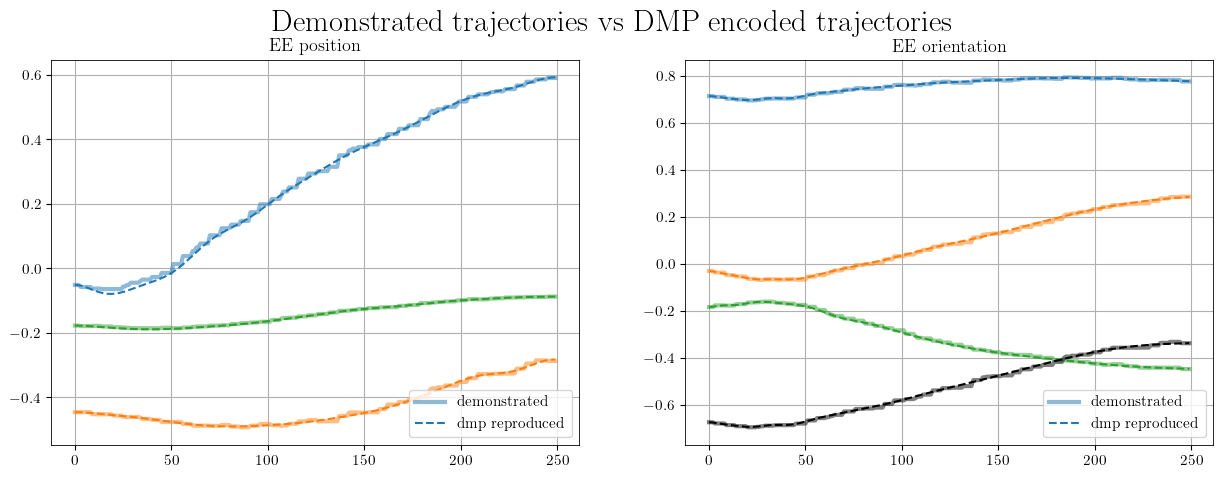

In [11]:
# plot dmps as subplots (pos, vel, acc) for position
tr = np.loadtxt("trajectories/trajectory_cart_rarm_short.txt")
traj_rarm = Trajectory(ts=tr[:,0], ys=tr[:,1:])

dmp = jc.loadjson("results_short_traj_3/dmp_rarm_initial.json")
ts_rarm = dmp.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp.analytical_solution()
traj_dmp = dmp.states_as_trajectory(ts_rarm, xs, xds)

colors = ["tab:blue", "tab:orange", "tab:green", "black", "tab:purple", "tab:gray"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i in range(3):
    ax1.plot(traj_rarm.ys[:,i], linestyle="-", linewidth=3, color=colors[i], alpha=0.5)
    ax1.plot(traj_dmp.ys[:,i], linestyle="--", linewidth=1.5, color=colors[i])
    ax1.set_title("EE position")
    
for i in range(4):
    ax2.plot(traj_rarm.ys[:,3+i], linestyle="-", linewidth=3, color=colors[i], alpha=0.5)
    ax2.plot(q_traj[:,i], linestyle="--", linewidth=1.5, color=colors[i])

    ax2.set_title("EE orientation")

fig.suptitle("Demonstrated trajectories vs DMP encoded trajectories", weight="bold", fontsize=22)
ax1.legend(["demonstrated", "dmp reproduced"], loc="lower right")
ax2.legend(["demonstrated", "dmp reproduced"])
ax1.grid()
ax2.grid()
plt.show()

# plot orientation dmp as subplots (pos, vel) for orientation

## Overall cost 

$J(\boldsymbol{\tau}_k) = w_{stab}J(\boldsymbol{\tau}_k)_{stab} + w_{Pgoal}J(\boldsymbol{\tau}_k)_{Pgoal} + w_{Rgoal}J(\boldsymbol{\tau}_k)_{Rgoal} + w_{traj}J(\boldsymbol{\tau}_k)_{traj}$

## Stability cost

$J(\boldsymbol{\tau}_k)_{stab} = \frac{1}{N+1}\sum_{i=0}^N f_{stab}(\boldsymbol{x}_{ZMP}(t_i))$

## Position goal cost 

$J(\boldsymbol{\tau}_k)_{Pgoal} =  ||\boldsymbol{x}_{ee}(T) - \boldsymbol{g})||^2$

## Orientation goal cost 

$J(\boldsymbol{\tau}_k)_{Rgoal} =  ||\boldsymbol{rpy}_{ee}(T) - \boldsymbol{rpy}_{g})||^2$

## Trajectory cost

$J(\boldsymbol{\tau}_k)_{traj} =  \frac{1}{N+1}\sum_{i=0}^N  \|\boldsymbol{\tau}(t_i) - \boldsymbol{\tau}_{demonstrated}(t_i)\|^2$

or    

$J(\boldsymbol{\tau}_k)_{traj} =  \frac{1}{3}\sum_{i=0}^3  DTW(\boldsymbol{\tau}_k,\boldsymbol{\tau}_{demonstrated})$

In [12]:
results_folder_no_goal_deviation = "results_short_traj_no_goal_deviation/"
results_folder_no_goal_dtw =       "results_short_traj_no_goal_dtw/"
results_folder_goal_deviation =    "results_short_traj_3/"
# results_folder_goal_dtw =          "results_short_traj_goal_dtw/"
results_folder_goal_dtw =          "results_learning_wb_goal_covar_adapt_short_traj_8/"



# <b> Different learning configurations cost comparison </b>

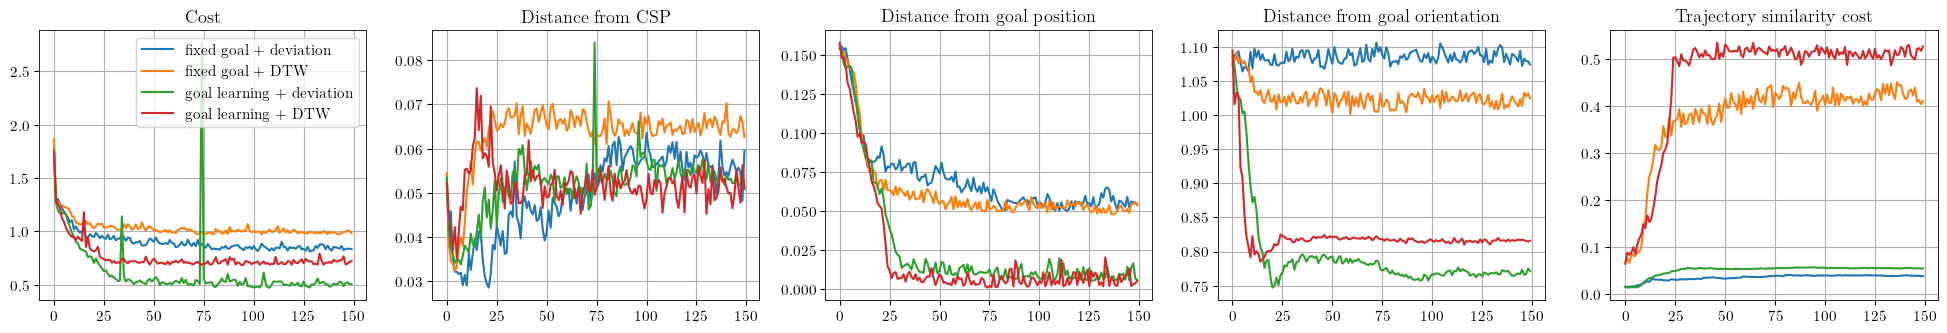

In [21]:
with open(results_folder_no_goal_deviation + '/plot_configs.json') as config_file:
    plot_configs = json.load(config_file)

weights = plot_configs["weights"]
titles = plot_configs["titles"]

labels = ["fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"]
fig, axs = plt.subplots(1, len(df_no_goal_deviation.columns), figsize=(4.9*len(df_no_goal_deviation.columns), 3.5))
for i, col in enumerate(df_no_goal_deviation.columns):
    axs[i].plot(df_no_goal_deviation[col][df_no_goal_deviation["cost"]<10]/weights[col], label=labels[0])
    axs[i].plot(df_no_goal_dtw[col][df_no_goal_dtw["cost"]<10]/weights[col], label=labels[1])
    axs[i].plot(df_goal_devation[col][df_goal_devation["cost"]<10]/weights[col], label=labels[2])
    axs[i].plot(df_goal_dtw[col][df_goal_dtw["cost"]<10]/weights[col], label=labels[3])
    axs[i].set_title(titles[col])
    axs[i].grid()
axs[0].legend(loc="upper right")
plt.show()


# <b> Different learning configurations EE trajectory comparison </b>

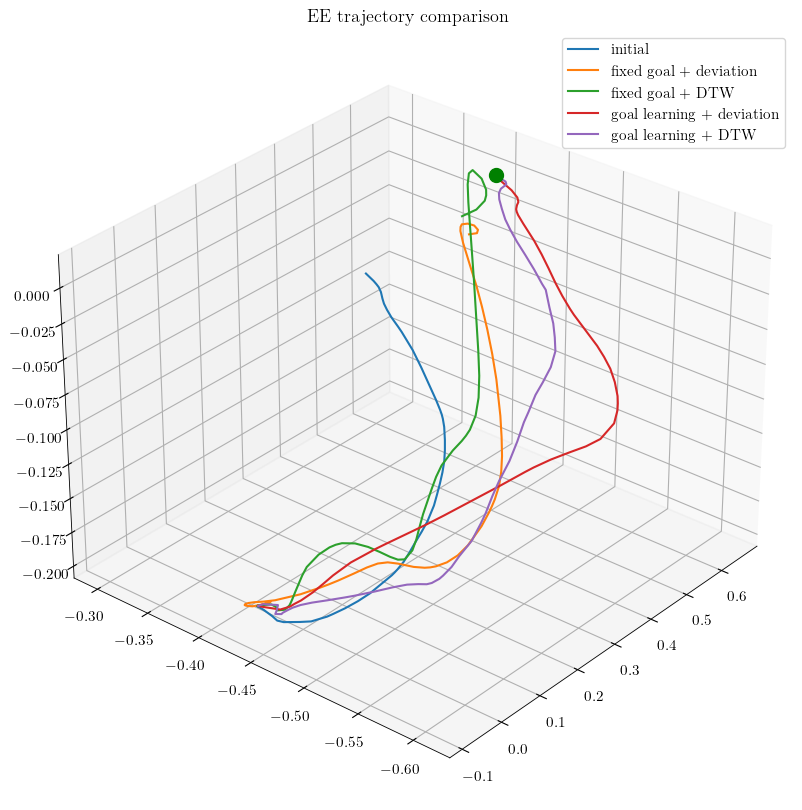

In [22]:

# cost_vars_0 = np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00000/eval_cost_vars.txt")
# cost_vars_no_goal_deviation = np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_no_goal_dtw = np.loadtxt(results_folder_no_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_goal_deviation = np.loadtxt(results_folder_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_goal_dtw = np.loadtxt(results_folder_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt")
cost_varss = [np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00000/eval_cost_vars.txt"),
             np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt"),
             np.loadtxt(results_folder_no_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt"),
             np.loadtxt(results_folder_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt"),
             np.loadtxt(results_folder_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt")]

labels = ["initial", "fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"]
n_misc = 15



fig3d = plt.figure(figsize=(10,10))
# ax = Axes3D(fig3d)
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
# for i in [-1]:
#     R_0 = matrix_from_quaternion(Q_0[i])
#     p_0 = pos_0[i]
#     R_T = matrix_from_quaternion(Q_T[i])
#     p_T = pos_T[i]
#     ax = plot_basis(ax=ax, s=0.05, R=R_0, p=p_0)
#     ax = plot_basis(ax=ax, s=0.05, R=R_T, p=p_T)
# ax = plot_basis(ax=ax, s=0.05, R=matrix_from_quaternion([0.5, 0.5, -0.5, -0.5]), p=[0.65,-0.4, 0.0])

ax.legend()
ax.set_title("EE trajectory comparison")
# plt.savefig(results_folder+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
plt.show()

In [29]:
avg_df = pd.DataFrame(columns = ["initial", "fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"],
                      index = ["Average distance from SCP", "Distance from goal position", "Distance from goal orientation"])

avg_df["initial"].loc["Average distance from SCP"]                   = calculate_dist_to_cop(cost_varss[0])
avg_df["fixed goal + deviation"].loc["Average distance from SCP"]    = df_no_goal_deviation["stab_cost"].mean()
avg_df["fixed goal + DTW"].loc["Average distance from SCP"]          = df_no_goal_dtw["stab_cost"].mean()
avg_df["goal learning + deviation"].loc["Average distance from SCP"] = df_goal_devation["stab_cost"].mean()
avg_df["goal learning + DTW"].loc["Average distance from SCP"]       = df_goal_dtw["stab_cost"].mean()

goal_pos = [0.65, -0.4, 0.0]
avg_df["initial"].loc["Distance from goal position"]                   = np.linalg.norm(cost_varss[0][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["fixed goal + deviation"].loc["Distance from goal position"]    = np.linalg.norm(cost_varss[1][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["fixed goal + DTW"].loc["Distance from goal position"]          = np.linalg.norm(cost_varss[2][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["goal learning + deviation"].loc["Distance from goal position"] = np.linalg.norm(cost_varss[3][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["goal learning + DTW"].loc["Distance from goal position"]       = np.linalg.norm(cost_varss[4][-1,-n_misc+2:-n_misc+5] - goal_pos)

avg_df["initial"].loc["Distance from goal orientation"]                   = 1.0725496801934065
avg_df["fixed goal + deviation"].loc["Distance from goal orientation"]    = df_no_goal_deviation["orient_cost"].iloc[-1]/0.5
avg_df["fixed goal + DTW"].loc["Distance from goal orientation"]          = df_no_goal_dtw["orient_cost"].iloc[-1]/0.5
avg_df["goal learning + deviation"].loc["Distance from goal orientation"] = df_goal_devation["orient_cost"].iloc[-1]/0.5
avg_df["goal learning + DTW"].loc["Distance from goal orientation"]       = df_goal_dtw["orient_cost"].iloc[-1]/0.5




In [30]:
avg_df

,initial,fixed goal + deviation,fixed goal + DTW,goal learning + deviation,goal learning + DTW
Average distance from SCP,0.052807,0.061192,0.063156,0.051679,0.051831
Distance from goal position,0.154354,0.054033,0.053605,0.005464,0.005095
Distance from goal orientation,1.07255,1.073908,1.024264,0.771276,0.815776


## <b> Learning the trajectory with fixed goal and trajectory deviation </b>

params = ['weights']

### Cost evaluation

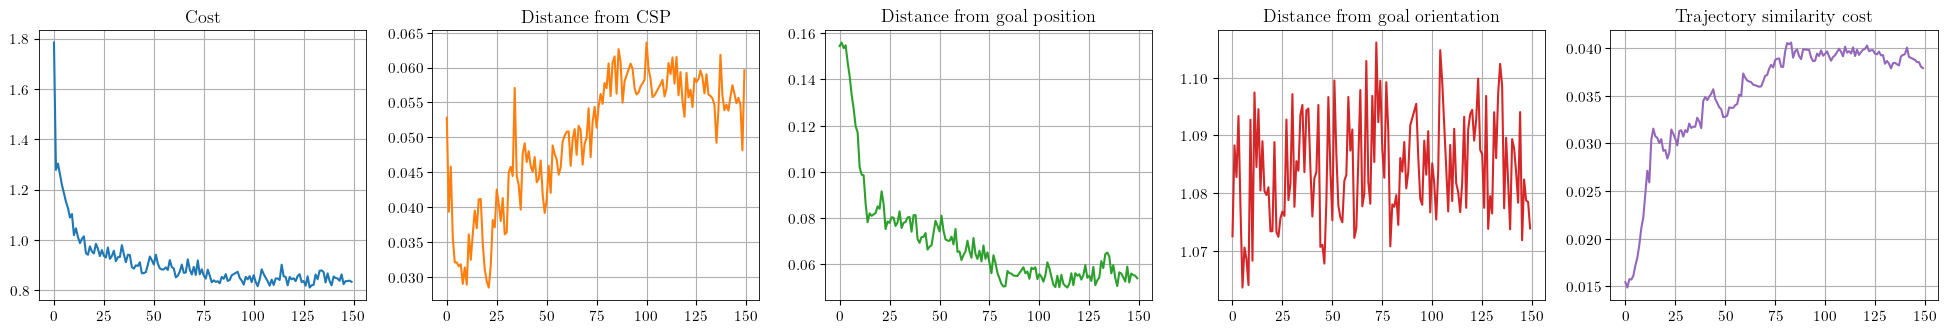

In [13]:
df_no_goal_deviation = plot_costs(results_folder_no_goal_deviation, subplots=True)

### ZMP and EE trajectories evaluation

In [14]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_deviation))
    s = plot_ee_traj(results_folder_no_goal_deviation)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_deviation))
    s2 = plot_cop(results_folder_no_goal_deviation)

two_columns = widgets.HBox([output1, output2])
display(two_columns)

## <b> Learning the trajectory with fixed goal and DTW for trajectory similarity </b>

params = ["weights"]

### Cost evaluation

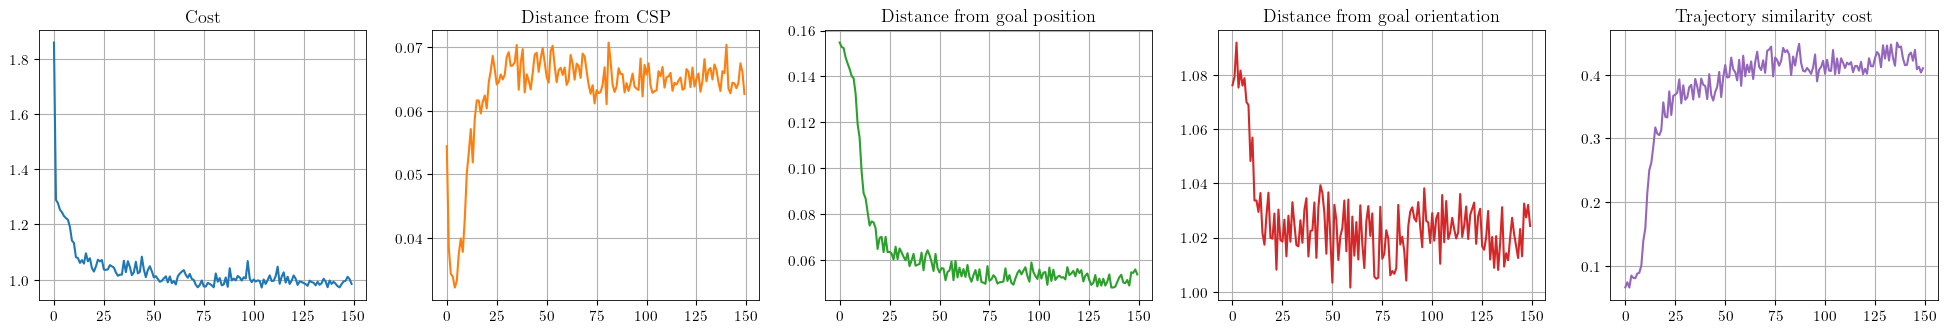

In [15]:
df_no_goal_dtw = plot_costs(results_folder_no_goal_dtw, subplots=True)

### ZMP and EE trajectories evaluation

In [16]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_dtw))
    s = plot_ee_traj(results_folder_no_goal_dtw)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_dtw))
    s = plot_cop(results_folder_no_goal_dtw)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

## <b> Learning the weights and the goal of the trajectory with DTW for trajectory similarity </b>

params = ["weights", "goal"]

### Cost evaluation

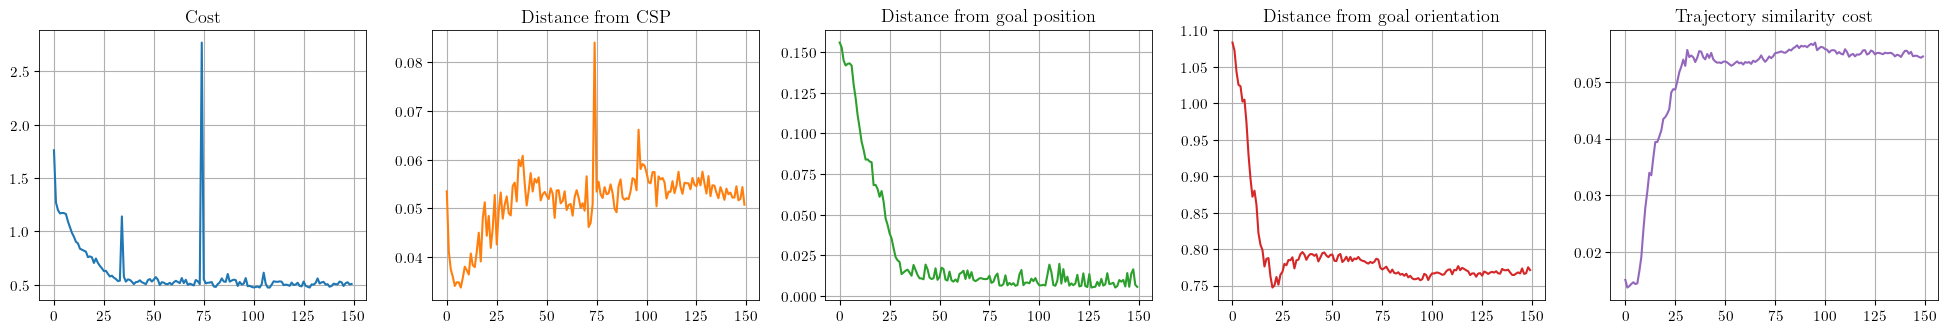

In [17]:
df_goal_devation = plot_costs(results_folder_goal_deviation, subplots=True)

### ZMP and EE trajectories evaluation

In [18]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_deviation))
    s = plot_ee_traj(results_folder_goal_deviation)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_goal_deviation))
    s2 = plot_cop(results_folder_goal_deviation)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

## <b> Learning the weights and the goal of the trajectory with DTW for trajectory similarity </b>

params = ["weights", "goal"]

### Cost evaluation

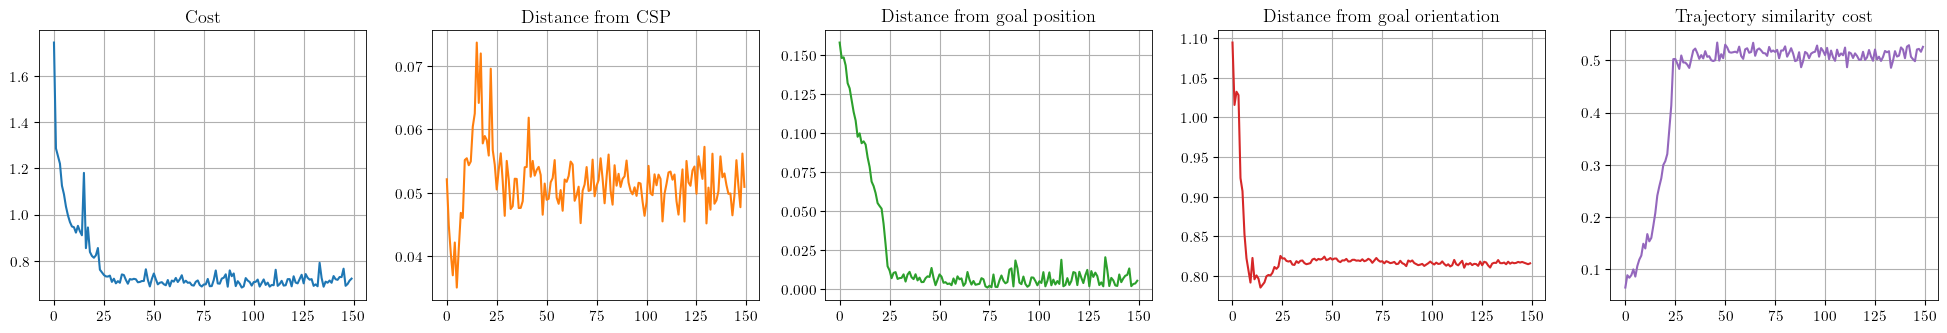

In [19]:
df_goal_dtw = plot_costs(results_folder_goal_dtw, subplots=True)

### ZMP and EE trajectories evaluation

In [20]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_dtw))
    s = plot_ee_traj(results_folder_goal_dtw)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_goal_dtw))
    s2 = plot_cop(results_folder_goal_dtw)
    

two_columns = widgets.HBox([output1, output2])
display(two_columns)

In [33]:
!jupyter nbconvert plot_results.ipynb --no-input --to html

[NbConvertApp] Converting notebook plot_results.ipynb to html
[NbConvertApp] Writing 2469502 bytes to plot_results.html
